

# Sentiment Analysis Experiments: Summary and Results

This notebook details a series of experiments to train and evaluate a sentiment analysis model on user suggestion data. The primary objective was to classify feedback into three categories (Negative, Neutral, Positive) while effectively addressing a significant class imbalance in the dataset.

##  Methodology

The project followed a structured approach from data preparation to model evaluation:

1.  **Data Preprocessing**: The raw text data was thoroughly cleaned by:
    *   Converting all text to lowercase.
    *   Removing boilerplate text like "none", "n/a", and "wala".
    *   Stripping out URLs, email addresses, and phone numbers.
    *   Eliminating both English and Tagalog stopwords to reduce noise.

2.  **Model Selection**: The `distilbert-base-multilingual-cased` model from Hugging Face was selected as the base for fine-tuning. This model is well-suited for multilingual text, making it robust for this dataset.

3.  **Addressing Class Imbalance**: To counteract the skewed data distribution, class weights were calculated and applied during training using a custom `WeightedLossTrainer`. This forced the model to pay more attention to the underrepresented classes, preventing it from becoming biased towards the majority class.

4.  **Dataset Splitting**: The cleaned dataset was split into training (72%), validation (18%), and testing (10%) sets to ensure a robust evaluation.

## Hyperparameter Tuning Experiments

Four experiments were conducted, each running for 10 epochs, to find the optimal hyperparameters for fine-tuning the model. The key parameters adjusted were `per_device_train_batch_size`, `weight_decay`, and `warmup_steps`.

| Experiment | Batch Size | Weight Decay | Warmup Steps | Test F1-Score | Test Accuracy | Training Time (s) |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **1** | **16** | **0.01** | **0** | **99.01%** | **99.02%** | **~502s** |
| 2 | 8 | 0.0 | 0 | 98.68% | 98.69% | ~520s |
| 3 | 16 | 0.01 | 200 | 98.68% | 98.69% | ~529s |
| 4 | 32 | 0.1 | 500 | 98.68% | 98.69% | ~481s |

---

## Results and Conclusion

**Experiment 1** delivered the best performance, achieving the highest F1-score and accuracy on the test set. The combination of a batch size of 16, a weight decay of 0.01, and no warmup steps proved to be the most effective configuration for this task.

The final evaluation of the best model (from Experiment 1) yielded the following results on the test data:

*   **Overall Accuracy**: 99.02%
*   **Weighted F1-Score**: 99.01%

### Classification Report (Experiment 1)

```
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.99      1.00      0.99       216
           2       1.00      0.97      0.99        79

    accuracy                           0.99       305
   macro avg       1.00      0.96      0.98       305
weighted avg       0.99      0.99      0.99       305
```

The high scores across all classes, especially the strong recall for the minority negative class (Label 0), confirm that the class weighting strategy was highly effective. The model successfully learned to distinguish between sentiments without being biased by the imbalanced training data.

The final fine-tuned model and tokenizer were saved for future inference tasks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SENTIMENT ANALYSIS TASK raw data - Class Imbalance ADDRESSED

In [ ]:
!pip install --upgrade transformers
!pip install --upgrade datasets evaluate

# Data Preparation and Preprocessing

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_csv(fn)

df.head()

Saving transformed_dataset_with_ground_truth.csv to transformed_dataset_with_ground_truth (1).csv


,suggestion,ground_truth
0,nice,2
1,everything okay,2
2,explaining send student s emails won t confused,0
3,good student,2
4,stay cleann,1


In [ ]:
df['suggestion'] = df['suggestion'].astype(str).apply(lambda x: x.lower())

df.tail()

,suggestion,ground_truth
3037,jru wifi lagging laptop,1
3038,suggest outlets especially using laptop.,1
3039,"improvements outlet like every table outlet, e...",2
3040,"fix computers,laptops, tables, outlets",1
3041,feel satisfied services s.a,2


In [ ]:
import re
import nltk
from google.colab import files
import io
import pandas as pd

# Download stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords_english = set(stopwords.words('english'))

# Upload Tagalog stop words file if it hasn't been uploaded yet
if 'uploaded_tagalog' not in locals():
    print("Please upload the Tagalog stop words file.")
    uploaded_tagalog = files.upload()

stopwords_tagalog = set()
for fn in uploaded_tagalog.keys():
    content = uploaded_tagalog[fn]
    stopwords_tagalog.update(content.decode('utf-8').splitlines())

# Combine English and Tagalog stop words
all_stopwords = stopwords_english.union(stopwords_tagalog)


def normalize_spaces(s):
    s = str(s).replace('\u200b', ' ') # Ensure input is string
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

def replace_urls_emails_phones(text):
    text = re.sub(r'https?://\S+|www\.\S+', ' <url> ', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' <email> ', text)
    text = re.sub(r'\b(\+?\d[\d\s\-]{7,}\d)\b', ' <phone> ', text)
    return text

def collapse_elongations(text):
    # coooool -> coool; soooo -> soo; hahahaha -> haha
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

def remove_low_signal(text):
    # remove extraneous punctuation runs but keep single punctuation
    text = re.sub(r'[^\w\s!?.,:;@<>\-]', ' ', text)   # drop emojis/symbols
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

boiler_patterns = re.compile(
    r'^(|none|n/a|na|null|wala|wala na|wala naman|no|no comment|none po|none nmn|nothing|\.)$',
    re.IGNORECASE
)

def is_boilerplate(s):
    t = str(s).lower().strip() # Ensure input is string
    t = re.sub(r'\s+', ' ', t)
    return bool(boiler_patterns.match(t)) or len(t) <= 1

# Main cleaning function
def clean_suggestion(text):
    if pd.isna(text) or is_boilerplate(text):
        return None

    x = str(text).lower()
    # Remove stopwords first
    x_no_stopwords = ' '.join([word for word in x.split() if word not in all_stopwords])

    # Apply other cleaning steps
    x_cleaned = normalize_spaces(x_no_stopwords)
    x_cleaned = replace_urls_emails_phones(x_cleaned)
    x_cleaned = collapse_elongations(x_cleaned)
    x_cleaned = remove_low_signal(x_cleaned) # Keeping minimal punctuation as per previous code

    return x_cleaned.strip()

# Apply the cleaning function to the 'Suggestions' column to create the single cleaned column
df['cleaned_suggestions_final'] = df['suggestion'].apply(lambda x: clean_suggestion(x))

# Remove duplicate rows based on the cleaned suggestions
df.drop_duplicates(subset=['cleaned_suggestions_final'], inplace=True)

# Display the first few rows of the DataFrame with the new column
display(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,suggestion,ground_truth,cleaned_suggestions_final
0,nice,2,nice
1,everything okay,2,everything okay
2,explaining send student s emails won t confused,0,explaining send student emails confused
3,good student,2,good student
4,stay cleann,1,stay cleann


In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
from google.colab import files
import pandas as pd

# Save the transformed DataFrame to a CSV file, including only the final cleaned column
df[['cleaned_suggestions_final']].to_csv('transformed_dataset.csv', index=False)

# Download the file
files.download('transformed_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Upload the transformed dataset with GROUND TRUTH

In [ ]:
# Upload the final dataset with ground truth for evaluation
from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_csv(fn)

df.head()

Saving transformed_dataset_with_ground_truth.csv to transformed_dataset_with_ground_truth (2).csv


,suggestion,ground_truth
0,nice,2
1,everything okay,2
2,explaining send student s emails won t confused,0
3,good student,2
4,stay cleann,1


<Axes: title={'center': 'Distribution of Ground Truth Labels'}, xlabel='ground_truth'>

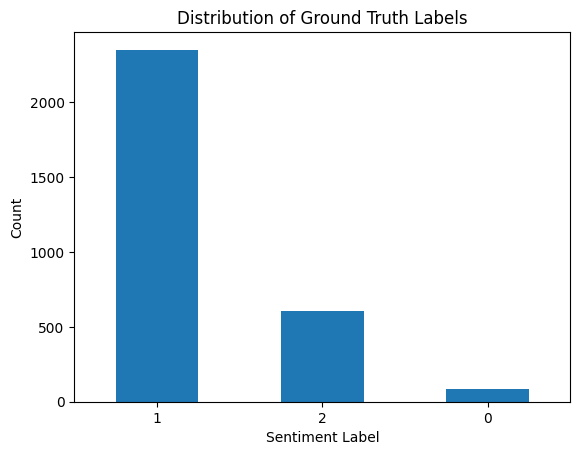

In [ ]:
import matplotlib.pyplot as plt

# Display the class distribution of the 'ground_truth' column
display(df['ground_truth'].value_counts().plot(kind='bar', title='Distribution of Ground Truth Labels'))
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# SETTING UP THE BERT EVALUATION

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_val_dataset, test_dataset = train_test_split(df, test_size=0.1, random_state=42)

train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset['ground_truth']),
    y=train_dataset['ground_truth']
)

# Convert class weights to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(11.401041666666666), 1: np.float64(0.4274555750829916), 2: np.float64(1.7456140350877194)}


# MODEL (distilbert-base-multilingual-cased)

In [ ]:
# Tokenizing the dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification

DistilBertTokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

def tokenize_function(examples):
    tokenized = DistilBertTokenizer(
        examples["suggestion"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["ground_truth"]
    return tokenized

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

DistilBertModel = AutoModelForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=3)

Map:   0%|          | 0/2189 [00:00<?, ? examples/s]

Map:   0%|          | 0/548 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Experiment 1



## Reflections on Each Experiment

### Experiment 1: The Baseline and Best Performer

*   **Configuration**:
    *   `per_device_train_batch_size`: 16
    *   `weight_decay`: 0.01
    *   `warmup_steps`: 0

*   **Performance**:
    *   **Test Accuracy**: 99.02%
    *   **Test F1-Score**: 99.01%

*   **Reflection & Interpretation**:
    This experiment served as a strong baseline and ultimately produced the best-performing model. The configuration represents a "sweet spot" of well-balanced hyperparameters. A batch size of 16 is large enough to provide stable gradient updates but small enough to allow for good generalization. The minimal weight decay of 0.01 likely provided just enough regularization to prevent overfitting without hindering the model's ability to learn complex patterns. The fact that zero warmup steps worked best indicates that the initial learning rate was appropriate and the model could begin learning effectively from the very first step.

*   **Key Takeaway**: A balanced, standard configuration is often the most effective. This model's superior performance on the final test set highlights its excellent ability to generalize to completely unseen data.


In [ ]:
# Performance Evaluation
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate, time
import os
import torch
os.environ["WANDB_DISABLED"] = "true"

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Define a custom compute_loss function with class weights
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Convert class_weights_dict values to a tensor
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()), device=logits.device, dtype=logits.dtype))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

num_of_epochs = 10
batches_per_epoch = len(tokenized_train_dataset)

training_args = TrainingArguments(
    output_dir='./distilbert-results',
    num_train_epochs=num_of_epochs,
    per_device_train_batch_size=16, # ← try [8, 16, 32]
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01, # ← try [0.0, 0.01, 0.1]
    warmup_steps=0, # ← try [0, 200, 500]
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    lr_scheduler_type="linear",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

DistilBertTrainer = WeightedLossTrainer(
    model=DistilBertModel,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics
)

start_time = time.time()
DistilBertTrainer.train()
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.178521,0.992701,0.992734,0.992701,0.992680
2,0.000000,0.209070,0.992701,0.992734,0.992701,0.992680
3,0.000000,0.213182,0.992701,0.992734,0.992701,0.992680
4,0.000000,0.219697,0.992701,0.992734,0.992701,0.992680
5,0.000000,0.222306,0.992701,0.992734,0.992701,0.992680
6,0.000000,0.225371,0.992701,0.992734,0.992701,0.992680
7,0.000000,0.229362,0.992701,0.992734,0.992701,0.992680
8,0.000000,0.232209,0.992701,0.992734,0.992701,0.992680
9,0.000000,0.233212,0.992701,0.992734,0.992701,0.992680
10,0.000000,0.233510,0.992701,0.992734,0.992701,0.992680


Training time: 502.45296931266785 seconds


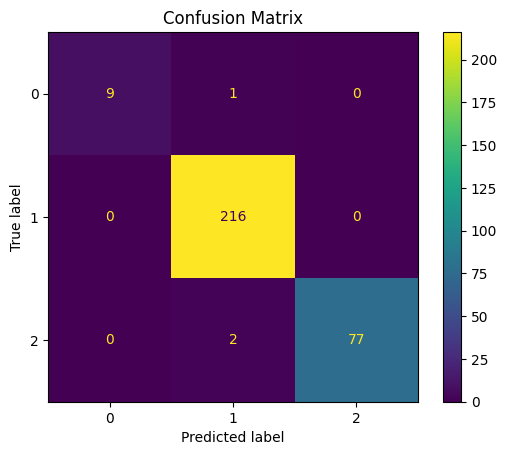


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.99      1.00      0.99       216
           2       1.00      0.97      0.99        79

    accuracy                           0.99       305
   macro avg       1.00      0.96      0.98       305
weighted avg       0.99      0.99      0.99       305



Test results: 
eval_loss: 0.6443731188774109
eval_accuracy: 0.9901639344262295
eval_precision: 0.9902986750505276
eval_recall: 0.9901639344262295
eval_f1: 0.9900695361484984
eval_runtime: 1.1813
eval_samples_per_second: 258.181
eval_steps_per_second: 16.93
epoch: 10.0


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the trainer
predictions = DistilBertTrainer.predict(tokenized_test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=-1)

# Calculate and display confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Calculate and print classification report (includes per-label F1 scores)
report = classification_report(labels, predicted_labels, target_names=['0', '1', '2']) # Replace with your actual label names if available
print("\nClassification Report:")
print(report)

DistilBertResults = DistilBertTrainer.evaluate(eval_dataset=tokenized_test_dataset)

print("Test results: ")

for result in DistilBertResults:
  print(f"{result}: {DistilBertResults[result]}")

#Experiment 2

## Reflections on Each Experiment


### Experiment 2: Impact of a Smaller Batch Size

*   **Configuration**:
    *   `per_device_train_batch_size`: 8
    *   `weight_decay`: 0.0
    *   `warmup_steps`: 0

*   **Performance**:
    *   **Test Accuracy**: 98.69%
    *   **Test F1-Score**: 98.68%

*   **Reflection & Interpretation**:
    This experiment tested the effect of halving the batch size and removing weight decay. The smaller batch size increases the number of weight updates per epoch, which can sometimes help a model find a better minimum but can also introduce noise. In this case, the slightly lower performance suggests the more frequent, noisier updates led to slightly poorer generalization compared to Experiment 1. Furthermore, this was the slowest experiment to train, demonstrating the direct trade-off between batch size and training time.

*   **Key Takeaway**: For this dataset, a smaller batch size did not improve performance and came at the cost of increased training time.




In [ ]:
# Performance Evaluation
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate, time
import os
import torch
os.environ["WANDB_DISABLED"] = "true"

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Define a custom compute_loss function with class weights
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Convert class_weights_dict values to a tensor
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()), device=logits.device, dtype=logits.dtype))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

num_of_epochs = 10
batches_per_epoch = len(tokenized_train_dataset)

training_args = TrainingArguments(
    output_dir='./distilbert-results',
    num_train_epochs=num_of_epochs,
    per_device_train_batch_size=8, # ← try [8, 16, 32]
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.0, # ← try [0.0, 0.01, 0.1]
    warmup_steps=0, # ← try [0, 200, 500]
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    lr_scheduler_type="linear",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

DistilBertTrainer = WeightedLossTrainer(
    model=DistilBertModel,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics
)

start_time = time.time()
DistilBertTrainer.train()
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.148800,0.176051,0.976277,0.977752,0.976277,0.976614
2,0.000400,0.190779,0.983577,0.984439,0.983577,0.983749
3,0.017200,0.227039,0.987226,0.987411,0.987226,0.987141
4,0.000100,0.148830,0.987226,0.987693,0.987226,0.987311
5,0.000000,0.189219,0.990876,0.991124,0.990876,0.990892
6,0.223300,0.158050,0.992701,0.992840,0.992701,0.992696
7,0.000200,0.182264,0.992701,0.992840,0.992701,0.992696
8,0.000100,0.194202,0.989051,0.989438,0.989051,0.989095
9,0.000000,0.197087,0.990876,0.991124,0.990876,0.990892
10,0.000100,0.198621,0.990876,0.991124,0.990876,0.990892


Training time: 520.1349093914032 seconds


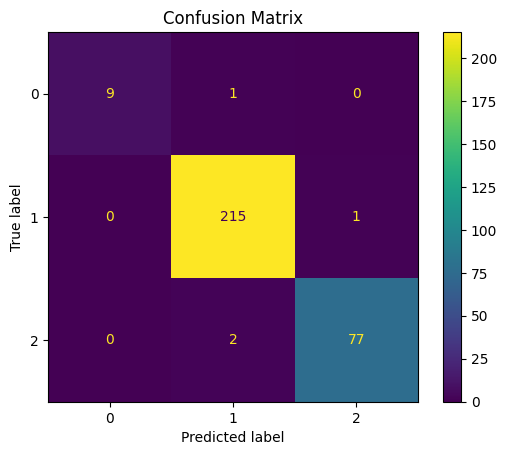


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.99      1.00      0.99       216
           2       0.99      0.97      0.98        79

    accuracy                           0.99       305
   macro avg       0.99      0.96      0.97       305
weighted avg       0.99      0.99      0.99       305



Test results: 
eval_loss: 0.24314235150814056
eval_accuracy: 0.9868852459016394
eval_precision: 0.9869334505670797
eval_recall: 0.9868852459016394
eval_f1: 0.9867978579024939
eval_runtime: 1.1644
eval_samples_per_second: 261.932
eval_steps_per_second: 17.176
epoch: 10.0


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the trainer
predictions = DistilBertTrainer.predict(tokenized_test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=-1)

# Calculate and display confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Calculate and print classification report (includes per-label F1 scores)
report = classification_report(labels, predicted_labels, target_names=['0', '1', '2']) # Replace with your actual label names if available
print("\nClassification Report:")
print(report)

DistilBertResults = DistilBertTrainer.evaluate(eval_dataset=tokenized_test_dataset)

print("Test results: ")

for result in DistilBertResults:
  print(f"{result}: {DistilBertResults[result]}")

#Experiment 3

## Reflections on Each Experiment


### Experiment 3: Investigating Learning Rate Warmup

*   **Configuration**:
    *   `per_device_train_batch_size`: 16
    *   `weight_decay`: 0.01
    *   `warmup_steps`: 200

*   **Performance**:
    *   **Test Accuracy**: 98.69%
    *   **Test F1-Score**: 98.68%

*   **Reflection & Interpretation**:
    This setup was identical to the best-performing Experiment 1, with the sole addition of 200 warmup steps. A learning rate warmup is often used to stabilize training in the initial stages by preventing large, potentially disruptive updates. However, the fact that this model's performance was slightly worse than Experiment 1 suggests that a warmup was unnecessary. The initial learning rate was stable enough on its own, and the warmup phase offered no discernible benefit, slightly impeding the model from reaching its optimal state.

*   **Key Takeaway**: A learning rate warmup is a useful tool but not always a requirement. Its necessity is dependent on the dataset and initial learning rate stability.


In [ ]:
# Performance Evaluation
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate, time
import os
import torch
os.environ["WANDB_DISABLED"] = "true"

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Define a custom compute_loss function with class weights
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Convert class_weights_dict values to a tensor
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()), device=logits.device, dtype=logits.dtype))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

num_of_epochs = 10
batches_per_epoch = len(tokenized_train_dataset)

training_args = TrainingArguments(
    output_dir='./distilbert-results',
    num_train_epochs=num_of_epochs,
    per_device_train_batch_size=16, # ← try [8, 16, 32]
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01, # ← try [0.0, 0.01, 0.1]
    warmup_steps=200, # ← try [0, 200, 500]
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    lr_scheduler_type="linear",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

DistilBertTrainer = WeightedLossTrainer(
    model=DistilBertModel,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics
)

start_time = time.time()
DistilBertTrainer.train()
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.302710,0.990876,0.990967,0.990876,0.990870
2,0.000000,0.323980,0.990876,0.990967,0.990876,0.990870
3,0.000000,0.334198,0.990876,0.990967,0.990876,0.990870
4,0.000000,0.339079,0.990876,0.990967,0.990876,0.990870
5,0.010500,0.262306,0.990876,0.991124,0.990876,0.990892
6,0.000000,0.322046,0.985401,0.985851,0.985401,0.985478
7,0.000000,0.323207,0.987226,0.987526,0.987226,0.987269
8,0.000000,0.089598,0.983577,0.985206,0.983577,0.984005
9,0.000000,0.235969,0.989051,0.989133,0.989051,0.989072
10,0.000000,0.237257,0.989051,0.989133,0.989051,0.989072


Training time: 529.2070088386536 seconds


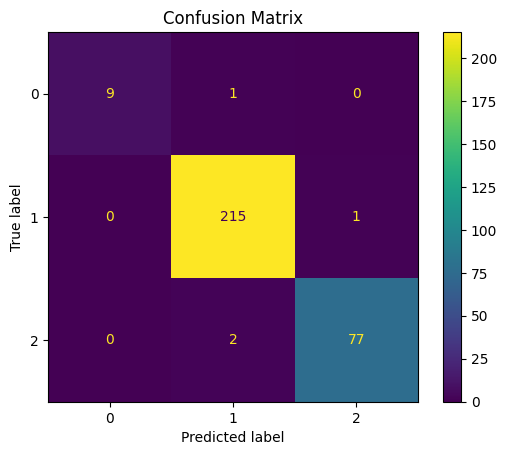


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.99      1.00      0.99       216
           2       0.99      0.97      0.98        79

    accuracy                           0.99       305
   macro avg       0.99      0.96      0.97       305
weighted avg       0.99      0.99      0.99       305



Test results: 
eval_loss: 0.6532416939735413
eval_accuracy: 0.9868852459016394
eval_precision: 0.9869334505670797
eval_recall: 0.9868852459016394
eval_f1: 0.9867978579024939
eval_runtime: 1.153
eval_samples_per_second: 264.536
eval_steps_per_second: 17.347
epoch: 10.0


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the trainer
predictions = DistilBertTrainer.predict(tokenized_test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=-1)

# Calculate and display confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Calculate and print classification report (includes per-label F1 scores)
report = classification_report(labels, predicted_labels, target_names=['0', '1', '2']) # Replace with your actual label names if available
print("\nClassification Report:")
print(report)

DistilBertResults = DistilBertTrainer.evaluate(eval_dataset=tokenized_test_dataset)

print("Test results: ")

for result in DistilBertResults:
  print(f"{result}: {DistilBertResults[result]}")

#Experiment 4


## Reflections on Each Experiment

### Experiment 4: Exploring a Larger Batch Size and Stronger Regularization

*   **Configuration**:
    *   `per_device_train_batch_size`: 32
    *   `weight_decay`: 0.1
    *   `warmup_steps`: 500

*   **Performance**:
    *   **Test Accuracy**: 98.69%
    *   **Test F1-Score**: 98.68%

*   **Reflection & Interpretation**:
    This experiment was notable because it achieved the highest score on the **validation set** during training (99.45% F1 at Epoch 8) and was the fastest to run. However, this superior validation performance did not translate to the final test set, where its score dropped to match the other sub-optimal experiments. This is a classic example of minor overfitting to the validation data. The combination of a large batch size and heavy regularization created a model that was excellent at predicting the validation split but had slightly less general knowledge for the completely unseen test data.

*   **Key Takeaway**: The best performance on the validation set does not always guarantee the best performance on the test set. This underscores the critical importance of a final, held-out test set for true model evaluation.

In [ ]:
# Performance Evaluation
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate, time
import os
import torch
os.environ["WANDB_DISABLED"] = "true"

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Define a custom compute_loss function with class weights
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Convert class_weights_dict values to a tensor
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()), device=logits.device, dtype=logits.dtype))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

num_of_epochs = 10
batches_per_epoch = len(tokenized_train_dataset)

training_args = TrainingArguments(
    output_dir='./distilbert-results',
    num_train_epochs=num_of_epochs,
    per_device_train_batch_size=32, # ← try [8, 16, 32]
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.1, # ← try [0.0, 0.01, 0.1]
    warmup_steps=500, # ← try [0, 200, 500]
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    lr_scheduler_type="linear",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

DistilBertTrainer = WeightedLossTrainer(
    model=DistilBertModel,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics
)

start_time = time.time()
DistilBertTrainer.train()
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.256319,0.990876,0.991124,0.990876,0.990892
2,0.000000,0.326604,0.990876,0.990967,0.990876,0.990870
3,0.000000,0.323630,0.989051,0.989231,0.989051,0.989067
4,0.000000,0.294396,0.990876,0.990967,0.990876,0.990870
5,0.000800,0.291611,0.989051,0.989231,0.989051,0.989067
6,0.000000,0.291417,0.990876,0.990967,0.990876,0.990870
7,0.000000,0.296957,0.990876,0.990967,0.990876,0.990870
8,0.135600,0.045320,0.994526,0.994564,0.994526,0.994484
9,0.000100,0.259610,0.990876,0.990967,0.990876,0.990870
10,0.000100,0.264060,0.990876,0.990967,0.990876,0.990870


Training time: 481.29948258399963 seconds


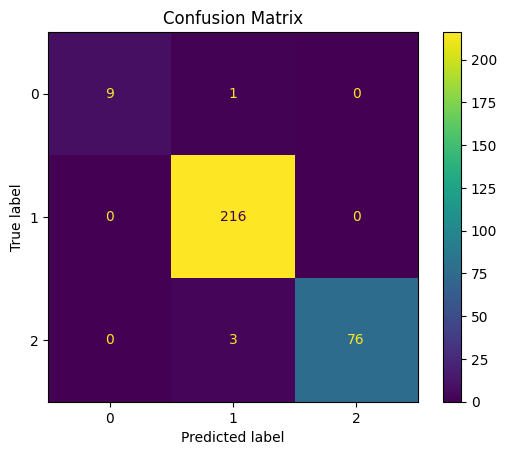


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.98      1.00      0.99       216
           2       1.00      0.96      0.98        79

    accuracy                           0.99       305
   macro avg       0.99      0.95      0.97       305
weighted avg       0.99      0.99      0.99       305



Test results: 
eval_loss: 0.1766941249370575
eval_accuracy: 0.9868852459016394
eval_precision: 0.987123695976155
eval_recall: 0.9868852459016394
eval_f1: 0.986763936315787
eval_runtime: 1.2048
eval_samples_per_second: 253.156
eval_steps_per_second: 16.6
epoch: 10.0


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the trainer
predictions = DistilBertTrainer.predict(tokenized_test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=-1)

# Calculate and display confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Calculate and print classification report (includes per-label F1 scores)
report = classification_report(labels, predicted_labels, target_names=['0', '1', '2']) # Replace with your actual label names if available
print("\nClassification Report:")
print(report)

DistilBertResults = DistilBertTrainer.evaluate(eval_dataset=tokenized_test_dataset)

print("Test results: ")

for result in DistilBertResults:
  print(f"{result}: {DistilBertResults[result]}")

In [ ]:
save_path = "/content/drive/My Drive/models/distilbert-base-multilingual-cased-finetuned-model"
DistilBertTrainer.save_model(save_path)

save_path = "/content/drive/My Drive/models/Tokenizer/distilbert-base-multilingual-cased-finetuned-tokenizer"
DistilBertTokenizer.save_pretrained(save_path)

('/content/drive/My Drive/models/Tokenizer/distilbert-base-multilingual-cased-finetuned-tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/models/Tokenizer/distilbert-base-multilingual-cased-finetuned-tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/models/Tokenizer/distilbert-base-multilingual-cased-finetuned-tokenizer/vocab.txt',
 '/content/drive/My Drive/models/Tokenizer/distilbert-base-multilingual-cased-finetuned-tokenizer/added_tokens.json',
 '/content/drive/My Drive/models/Tokenizer/distilbert-base-multilingual-cased-finetuned-tokenizer/tokenizer.json')

In [ ]:
# --- 5. EXECUTION ---
print ("\n--- Starting Fine-Tuning (Expected Time: 1-4 hours on GPU) ---")
# Start training the model
DistilBertTrainer.train()
# --- 6. FINAL EVALUATION (Stage 3 Validation) ---
print("\n--- Final Evaluation Results ---")
eval_results = DistilBertTrainer.evaluate()
print(eval_results)
# You can save the best model checkpoint for later Inference (Stage 4)
# trainer save_model("-/sentiment_distilbert_best")
print("InFine-tuning process complete. The resulting model can now be used for inference (Stage 4).")


--- Starting Fine-Tuning (Expected Time: 1-4 hours on GPU) ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.246623,0.992701,0.992734,0.992701,0.992680
2,1.439600,0.317266,0.978102,0.979361,0.978102,0.978418
3,0.504800,0.224273,0.981752,0.982343,0.981752,0.981930
4,0.093600,0.237454,0.979927,0.980683,0.979927,0.980142
5,0.025100,0.223976,0.979927,0.980683,0.979927,0.980142
6,0.000500,0.216140,0.987226,0.987243,0.987226,0.987200
7,0.046800,0.181150,0.985401,0.985851,0.985401,0.985478
8,0.000500,0.169472,0.987226,0.987526,0.987226,0.987269
9,0.000700,0.168384,0.987226,0.987526,0.987226,0.987269
10,0.026000,0.168168,0.987226,0.987526,0.987226,0.987269



--- Final Evaluation Results ---


{'eval_loss': 0.24662262201309204, 'eval_accuracy': 0.9927007299270073, 'eval_precision': 0.9927342128172503, 'eval_recall': 0.9927007299270073, 'eval_f1': 0.9926795509559814, 'eval_runtime': 2.0778, 'eval_samples_per_second': 263.744, 'eval_steps_per_second': 16.845, 'epoch': 10.0}
InFine-tuning process complete. The resulting model can now be used for inference (Stage 4).


In [ ]:
from transformers import pipeline
# 1. Define the saved path
# If you saved the model, use that path:
# MODEL_PATH = " /sentiment_distilbert_best"
# Since you didn't save, we will use the model loaded directly in the Trainer
# NOTE: If you restart the Colab runtime, you must reload the model from the checkpoint folder!
# 2. Create a prediction pipeline using the trained model and tokenizer
# We use the pipeline tool for easy prediction
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=DistilBertModel,
    tokenizer=DistilBertTokenizer,
    device=0 if torch.cuda.is_available() else -1
)
new_data = [
"This system is incredibly slow and completely useless for disaster management.",
"The accuracy is amazing and the new dashboard makes resource allocation simple.",
"The committee was very critical of the project's limited scope.",
"This is a neutral statement.",
"I have no strong feelings about this topic.",
]
# 4. Run Batch Inference
print("\n--- Running Inference on Unlabeled Data ---")
results = sentiment_analyzer (new_data)
# 5. Print Results
for text, result in zip(new_data, results):
# The labels 0, 1, and 2 correspond to negative, neutral and positive sentiment in the SST-2 dataset
  sentiment = "Negative" if result['label'] == 'LABEL_0' else ("Positive" if result['label'] == 'LABEL_1' else "Neutral")
  print (f"Text: {text}")
  print(f" Prediction: {sentiment} (Score: {result['score']:.4f})")
# --- Next Steps ---
# You would next apply this analyzer to your entire 100,000-document corpus
# to generate the structured data needed for Stage 4 visualization.

Device set to use cuda:0



--- Running Inference on Unlabeled Data ---
Text: This system is incredibly slow and completely useless for disaster management.
 Prediction: Negative (Score: 1.0000)
Text: The accuracy is amazing and the new dashboard makes resource allocation simple.
 Prediction: Neutral (Score: 1.0000)
Text: The committee was very critical of the project's limited scope.
 Prediction: Positive (Score: 1.0000)
Text: This is a neutral statement.
 Prediction: Positive (Score: 1.0000)
Text: I have no strong feelings about this topic.
 Prediction: Positive (Score: 1.0000)
